# DBS Projekt Crash Analyse

In unserem DBS Projekt wollen wir die unfallstatistiken des BFU analysieren.
Als input nehmen wir dafür folgende daten: https://data.geo.admin.ch/ch.astra.unfaelle-personenschaeden_alle/

## Projekt Setup

Da wir in diesem Projekt MongoDB verwenden, muss diese zuerst auf dem [lokalen system installiert werden](https://docs.mongodb.com/manual/installation/).

Als nächstes müssen die python dependencies installiert werden:

```sh
python3 -m pip install pymongo praw
```

In [45]:
from pathlib import Path
from bson.json_util import dumps

import matplotlib.pyplot as plt
import pandas as pd

import pymongo

In [71]:
plt.rcParams['figure.dpi'] = 200

In [2]:
db = pymongo.MongoClient("mongodb://localhost").dbs

## Daten importieren

Nach dem extrahieren des `.json` files können die Daten in die Datenbank importiert werden.
Wir können nicht mit dem `.json` file direkt arbeiten, da wir komplexe querys auf der Datenbank
ausfzühren wollen. Nun werden die daten importiert:

In [ ]:
DATA_PATH = Path(__file__).resolve().parent

raw_data = json.loads((DATA_PATH / "accidents.json").read_text())


# import all accidents into the database
for raw_accident in raw_data["features"]:
    db.accidents.insert({
        "involving_pedestrian": raw_accident["properties"]["AccidentInvolvingPedestrian"].lower() == "true",
        "involving_motorcycle": raw_accident["properties"]["AccidentInvolvingBicycle"].lower() == "true",
        "involving_bicycle": raw_accident["properties"]["AccidentInvolvingMotorcycle"].lower() == "true",
        "type": {
            "id": raw_accident["properties"]["AccidentType"],
            "name": raw_accident["properties"]["AccidentType_de"]
        },
        "location": {
            "canton": raw_accident["properties"]["CantonCode"],
            "coordinates": raw_accident["geometry"]["coordinates"]
        },
        "severity": {
            "id": raw_accident["properties"]["AccidentSeverityCategory"],
            "name": raw_accident["properties"]["AccidentSeverityCategory_de"]
        },
        "road_type": {
            "id": raw_accident["properties"]["RoadType"],
            "name": raw_accident["properties"]["RoadType_de"]
        },
        "timestamp": {
            "year": raw_accident["properties"]["AccidentYear"],
            "month": raw_accident["properties"]["AccidentMonth"],
            "hour": raw_accident["properties"]["AccidentHour"],
            "weekday": raw_accident["properties"]["AccidentWeekDay_en"]
        }
    })

## Daten analysieren

Nun haben wir die Daten in die MongoDB importiert und können nun mit der datenanalyse beginnen.


## TODO's

Was wollen wir zeigen:


- [x] Anzahl totale unfaelle
- [x] Anzahl tädliche und prozentualer anteil
- [x] Entwicklung (trend)
- [x] Unfaelle pro Wochentag
- [x] Sicherste / Unsicherste zeit
- [ ] Sicherste zeit nach Jahreszeit
- [ ] Sichere unsichere Strassentypen (hauptstrasse, autobahn ...)
- [ ] Karte mit unfallorten
- [ ] Unfall pro Kanton
- [ ] Graubuenden im Winter mehr?
- [ ] Sicherste Zeit, Sicherster Ort, Sicherster Jahreszeit
- [ ] Unfalltypen Haufigkeit, ...
- [ ] Hoehemeter pro koordinaten (auf welcher hoehe gibt es die meisten unfaelle)
- [ ] Sicherster Wohnort

In [15]:
total_accident_count = db.accidents.count_documents({})
print(f"total accidents: {total_accident_count}")

total accidents: 161320


In [13]:
lethal_accident_count = db.accidents.count_documents({
    "$expr": {"$eq": ["$severity.id", "as1"]}
})
print(f"total lethal accidents: {lethal_accident_count}")

total lethal accidents: 2171


In [12]:
print(f"percentage: {lethal_accident_count / total_accident_count}")

percentage: 0.013457723778824697


In [22]:
pedestrian_count = db.accidents.count_documents({
    "$expr": {"$eq": ["$involving_pedestrian", True]}
})
bicycle_count = db.accidents.count_documents({
    "$expr": {"$eq": ["$involving_bicycle", True]}
})
motorcycle_count = db.accidents.count_documents({
    "$expr": {"$eq": ["$involving_motorcycle", True]}
})
car_count = db.accidents.count_documents({
    "$and": [
        {"$expr": {"$eq": ["$involving_pedestrian",  False]}},
        {"$expr": {"$eq": ["$involving_bicycle",  False]}},
        {"$expr": {"$eq": ["$involving_motorcycle",  False]}}
    ]
})

print("accident involvment:")
print(f"  {pedestrian_count} ({pedestrian_count / total_accident_count * 100:.2f}%) pedestrians")
print(f"  {bicycle_count} ({bicycle_count / total_accident_count * 100:.2f}%) bikes")
print(f"  {motorcycle_count} ({motorcycle_count / total_accident_count * 100:.2f}%) motorcycles")
print(f"  {car_count} ({car_count / total_accident_count * 100:.2f}%) cars")

accident involvment:
  19470 (12.07%) pedestrians
  33699 (20.89%) bikes
  35705 (22.13%) motorcycles
  75750 (46.96%) cars


In [25]:
lethal_pedestrian_count = db.accidents.count_documents({
    "$and": [
        {"$expr": {"$eq": ["$severity.id", "as1"]}},
        {"$expr": {"$eq": ["$involving_pedestrian", True]}}
    ]
})
lethal_bicycle_count = db.accidents.count_documents({
    "$and": [
        {"$expr": {"$eq": ["$severity.id", "as1"]}},
        {"$expr": {"$eq": ["$involving_bicycle", True]}}
    ]
})
lethal_motorcycle_count = db.accidents.count_documents({
    "$and": [
        {"$expr": {"$eq": ["$severity.id", "as1"]}},
        {"$expr": {"$eq": ["$involving_motorcycle", True]}}
    ]
})
lethal_car_count = db.accidents.count_documents({
    "$and": [
        {"$expr": {"$eq": ["$severity.id", "as1"]}},
        {"$expr": {"$eq": ["$involving_pedestrian", False]}},
        {"$expr": {"$eq": ["$involving_bicycle", False]}},
        {"$expr": {"$eq": ["$involving_motorcycle", False]}}
    ]
})

print("lethal accident involvment:")
print(f"  {lethal_pedestrian_count} ({lethal_pedestrian_count / lethal_accident_count * 100:.2f}%) pedestrians")
print(f"  {lethal_bicycle_count} ({lethal_bicycle_count / lethal_accident_count * 100:.2f}%) bikes")
print(f"  {lethal_motorcycle_count} ({lethal_motorcycle_count / lethal_accident_count * 100:.2f}%) motorcycles")
print(f"  {lethal_car_count} ({lethal_car_count / lethal_accident_count * 100:.2f}%) cars")

lethal accident involvment:
  478 (22.02%) pedestrians
  489 (22.52%) bikes
  320 (14.74%) motorcycles
  914 (42.10%) cars


In [67]:
total_accident_by_year = pd.DataFrame(list(db.accidents.aggregate([
    {"$group" : {"_id": "$timestamp.year", "count": {"$sum": 1}}},
    {"$project": {
      "_id": 0,
      "year": "$_id",
      "count": 1,
    }},
    {"$sort": {"year": 1}},
])))
total_accident_by_year.set_index("year", inplace=True)

total_accident_by_year

,count
year,
2011,18990
2012,18148
2013,17473
2014,17803
2015,17736
2016,17577
2017,17799
2018,18033
2019,17761


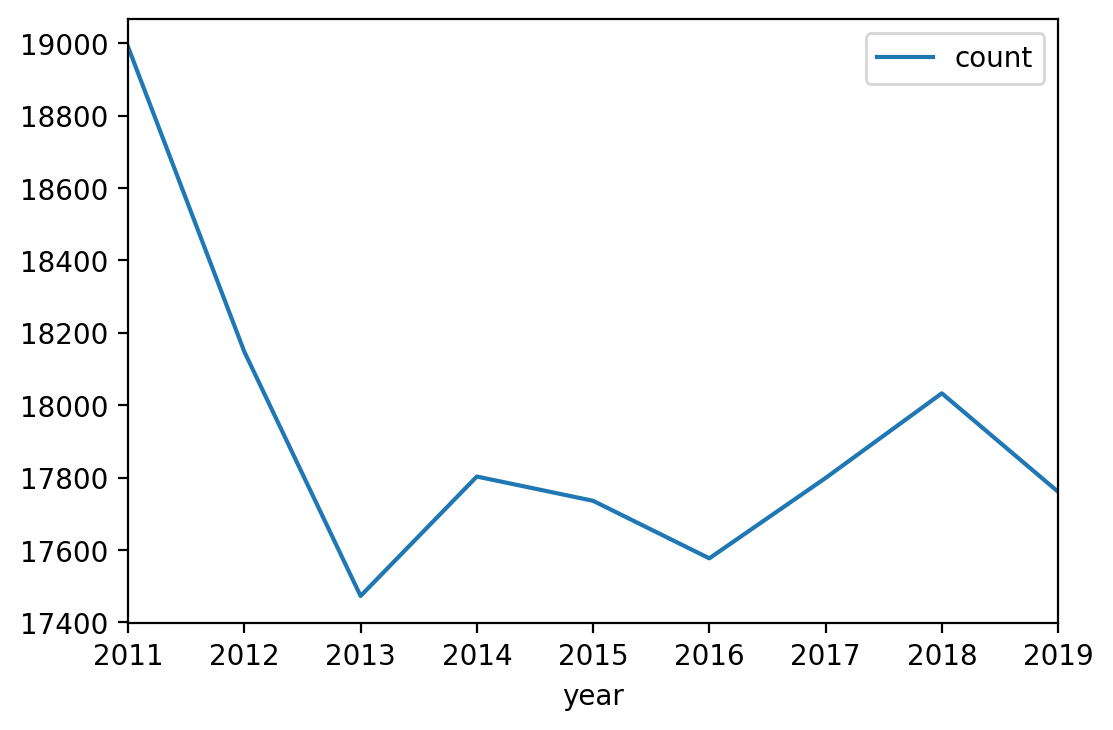

In [74]:
total_accident_by_year.plot()

In [78]:
lethal_accident_by_year = pd.DataFrame(list(db.accidents.aggregate([
    {"$match": {"severity.id": {"$eq": "as1"}}},
    {"$group" : {"_id": "$timestamp.year", "count": {"$sum": 1}}},
    {"$project": {
      "_id": 0,
      "year": "$_id",
      "count": 1,
    }},
    {"$sort": {"year": 1}},
])))
lethal_accident_by_year.set_index("year", inplace=True)

lethal_accident_by_year

,count
year,
2011,312
2012,301
2013,257
2014,229
2015,238
2016,208
2017,219
2018,228
2019,179


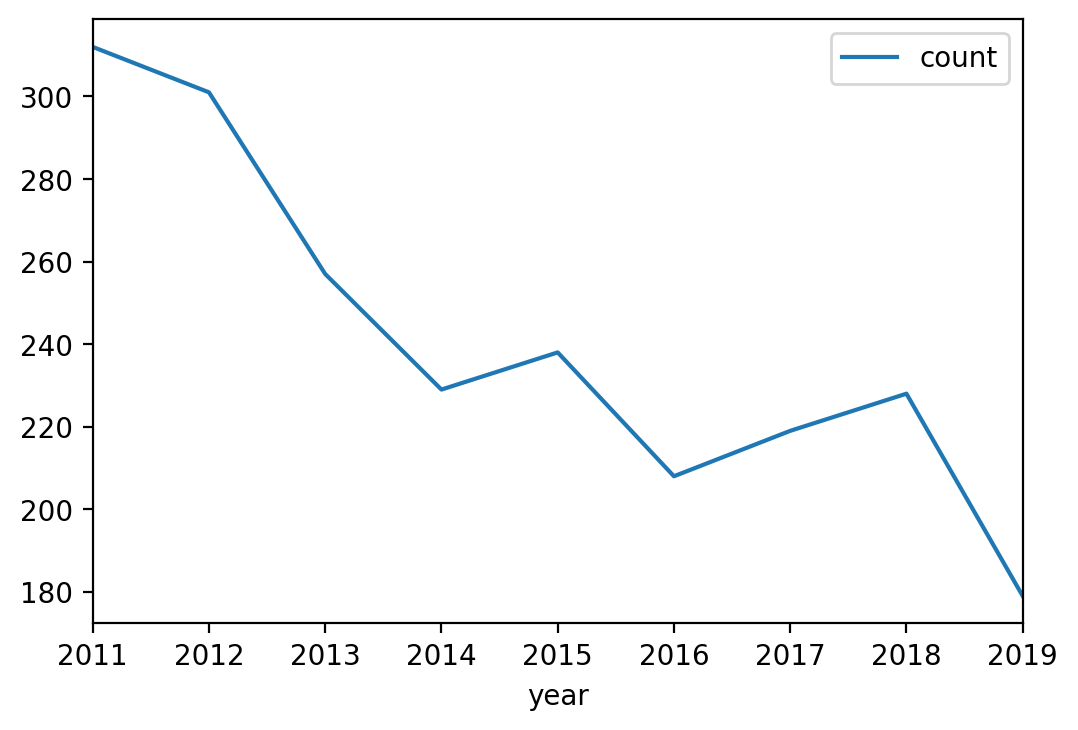

In [79]:

lethal_accident_by_year.plot()

In [92]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

lethal_accident_by_weekday = pd.DataFrame(list(db.accidents.aggregate([
    {"$match": {"severity.id": {"$eq": "as1"}}},
    {"$group" : {"_id": "$timestamp.weekday", "count": {"$sum": 1}}},
    {"$project": {
      "_id": 0,
      "weekday": "$_id",
      "count": 1,
    }},
    {"$sort": {"weekday": 1}},
])))
lethal_accident_by_weekday.set_index("weekday", inplace=True)
lethal_accident_by_weekday = lethal_accident_by_weekday.reindex(weekdays) 

lethal_accident_by_weekday

,count
weekday,
Monday,279
Tuesday,275
Wednesday,297
Thursday,337
Friday,374
Saturday,318
Sunday,291


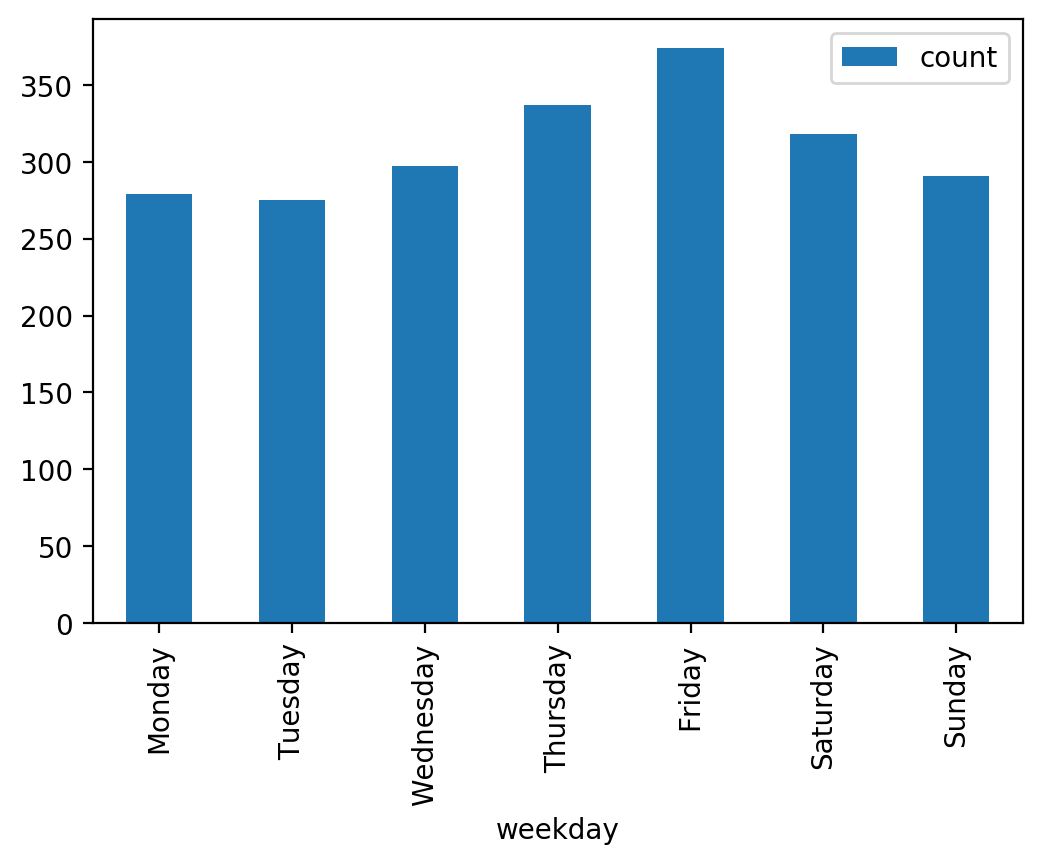

In [93]:
lethal_accident_by_weekday.plot.bar()

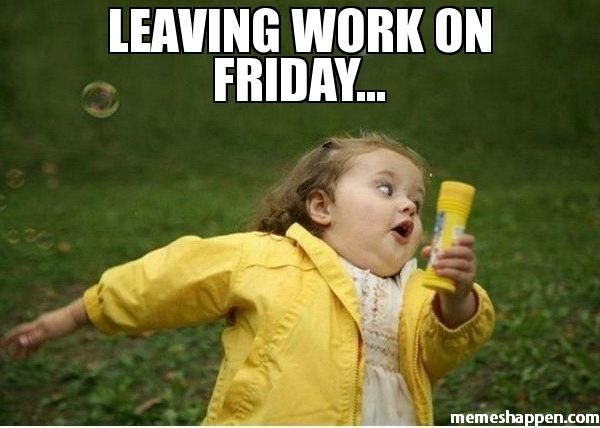

In [102]:
accident_by_hour = pd.DataFrame(list(db.accidents.aggregate([
    {"$group" : {"_id": "$timestamp.hour", "count": {"$sum": 1}}},
    {"$project": {
      "_id": 0,
      "hour": "$_id",
      "count": 1,
    }},
    {"$sort": {"hour": 1}},
])))
accident_by_hour.set_index("hour", inplace=True)

accident_by_hour

,count
hour,
,5
00,1956
01,1662
02,1391
03,1279
04,1315
05,2120
06,6408
07,9883


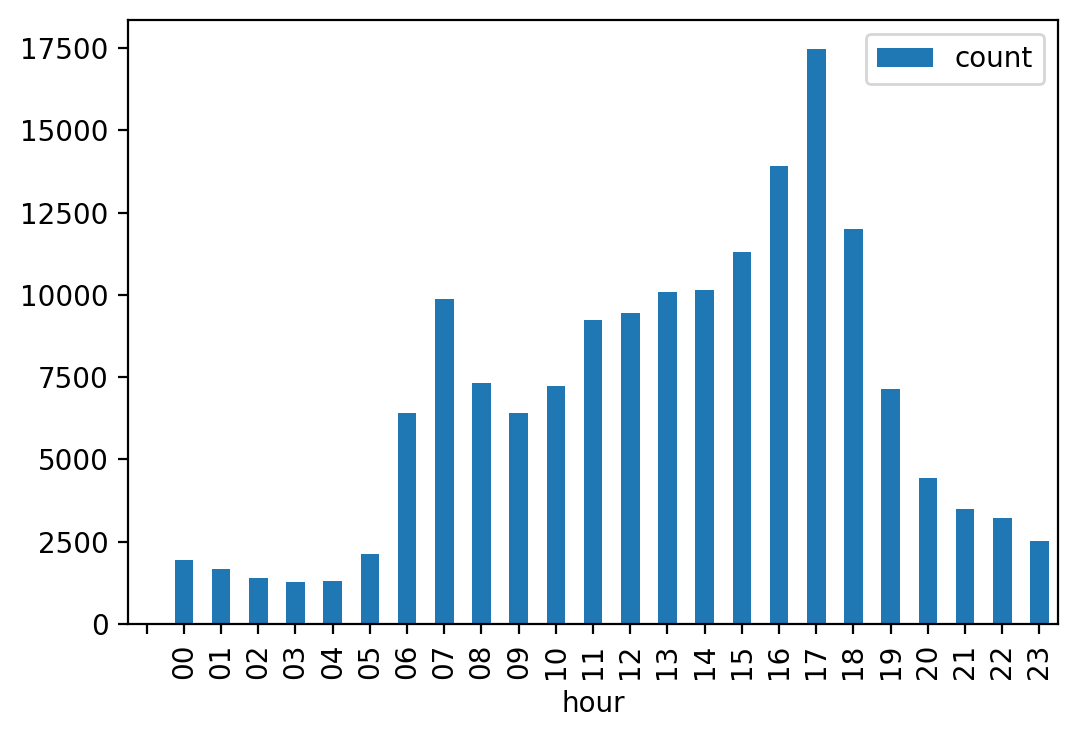

In [103]:
accident_by_hour.plot.bar()

In [104]:
lethal_accident_by_hour = pd.DataFrame(list(db.accidents.aggregate([
    {"$match": {"severity.id": {"$eq": "as1"}}},
    {"$group" : {"_id": "$timestamp.hour", "count": {"$sum": 1}}},
    {"$project": {
      "_id": 0,
      "hour": "$_id",
      "count": 1,
    }},
    {"$sort": {"hour": 1}},
])))
lethal_accident_by_hour.set_index("hour", inplace=True)

lethal_accident_by_hour

,count
hour,
00,48
01,36
02,27
03,38
04,30
05,51
06,78
07,65
08,90


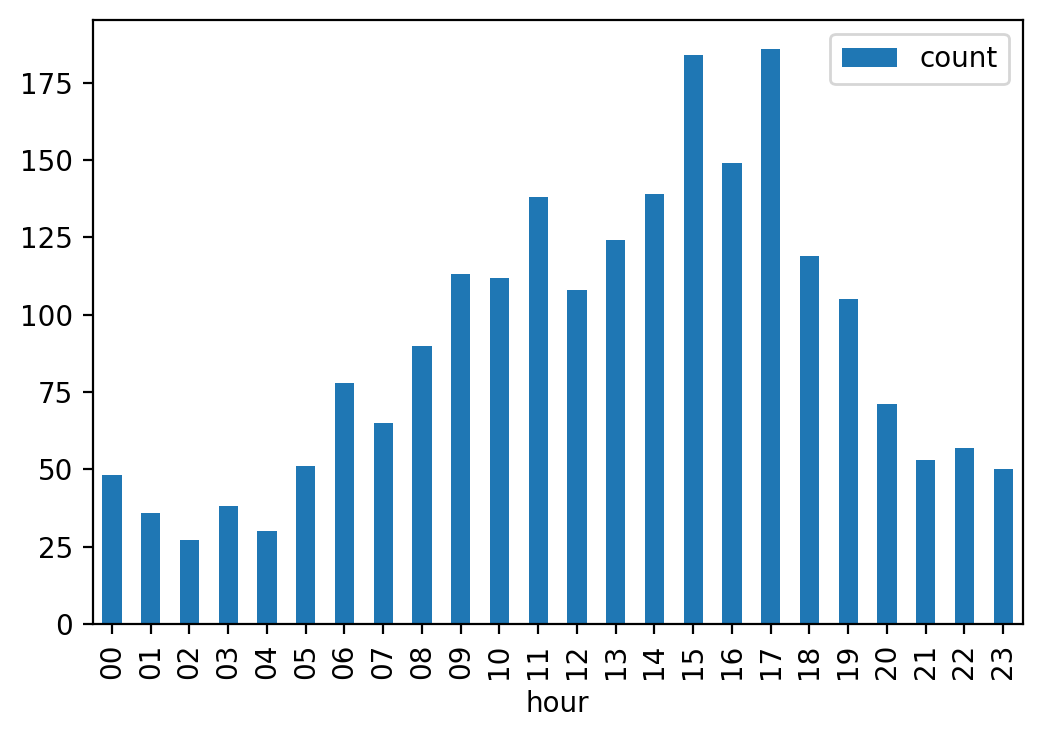

In [105]:
lethal_accident_by_hour.plot.bar()

In [111]:
lethal_accident_by_month = pd.DataFrame(list(db.accidents.aggregate([
    {"$match": {"severity.id": {"$eq": "as1"}}},
    {"$group" : {"_id": "$timestamp.month", "count": {"$sum": 1}}},
    {"$project": {
      "_id": 0,
      "month": "$_id",
      "count": 1,
    }},
    {"$sort": {"month": 1}},
    

])))
lethal_accident_by_month.set_index("month", inplace=True)

lethal_accident_by_month

,count
month,
1,147
10,182
11,183
12,173
2,101
3,155
4,176
5,213
6,210


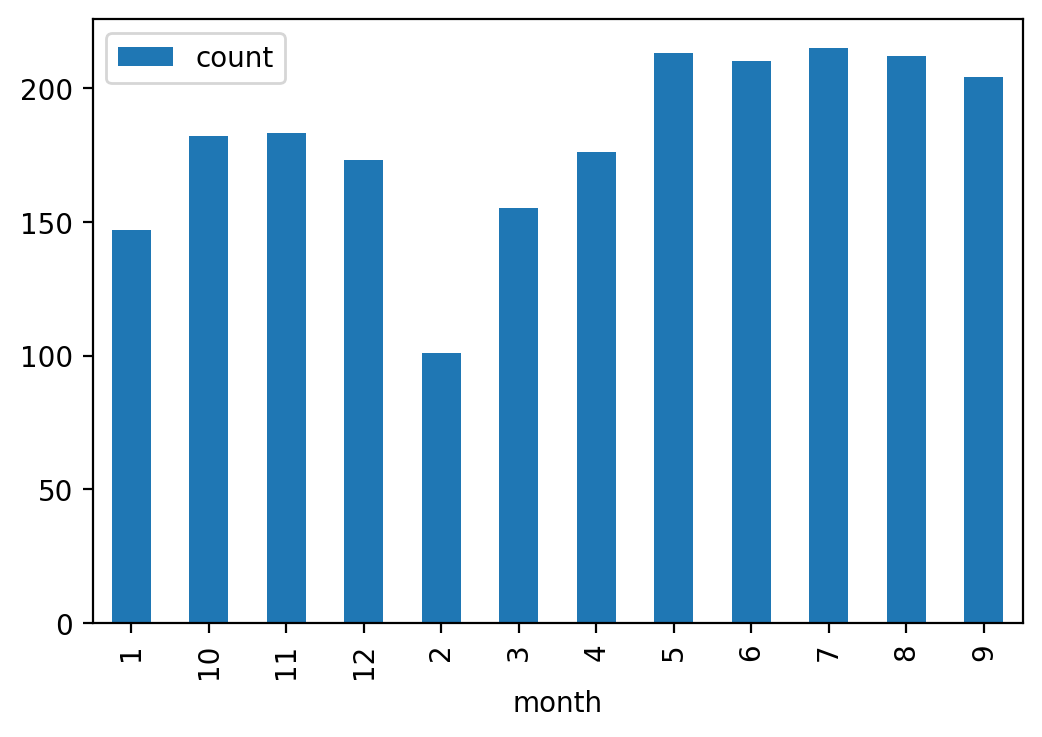

In [112]:
lethal_accident_by_month.plot.bar()